In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import sys
sys.path.append('../pp_1st')
sys.path.append('../pp_2nd')
sys.path.append('../pp_3rd')
import pp1st_pipeline
import pp1st_func
import pp2nd_func
import pp3_func
from sklearn.experimental import enable_iterative_imputer  
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import LabelEncoder
from xgboost.sklearn import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
import lightgbm as lgbm
from tqdm import tqdm
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 50)
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score

In [71]:
import importlib
importlib.reload(pp3_func)

<module 'pp3_func' from '../pp_3rd/pp3_func.py'>

In [2]:
data = pd.read_csv('../raw/PJT002_train.csv', )
data_val = pd.read_csv('../raw/PJT002_validation.csv' )
data_test = pd.read_csv('../raw/PJT002_test.csv')

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:3049: DtypeWarning: Columns (8,172,173,174,175,176,177,178,179) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
data = pp2nd_func.replace(data)
data = pp2nd_func.label_encoding(data)
data_val = pp2nd_func.replace(data_val)
data_val = pp2nd_func.label_encoding(data_val)

../pp_2nd/pp2nd_func.py:40: FutureWarning: The 'get_values' method is deprecated and will be removed in a future version. Use '.to_numpy()' or '.array' instead.
  data.loc[data['season']==0, 'season_mean_differ'] = data[data['season']==0]['tmprtr'].apply(lambda x : x - 13.893263003271683).get_values()
../pp_2nd/pp2nd_func.py:41: FutureWarning: The 'get_values' method is deprecated and will be removed in a future version. Use '.to_numpy()' or '.array' instead.
  data.loc[data['season']==1, 'season_mean_differ'] = data[data['season']==1]['tmprtr'].apply(lambda x : x - 24.737439966590106).get_values()
../pp_2nd/pp2nd_func.py:42: FutureWarning: The 'get_values' method is deprecated and will be removed in a future version. Use '.to_numpy()' or '.array' instead.
  data.loc[data['season']==2, 'season_mean_differ'] = data[data['season']==2]['tmprtr'].apply(lambda x : x - 15.416313269493845).get_values()
../pp_2nd/pp2nd_func.py:43: FutureWarning: The 'get_values' method is deprecated and will b

In [4]:
# data['mlt_us_yn_enc'] = data['mlt_us_yn'].apply(lambda x : 1 if x=='Y' else 0)
# data_val['mlt_us_yn_enc'] = data_val['mlt_us_yn'].apply(lambda x : 1 if x=='Y' else 0)

In [4]:
data = pp3_func.energy_mean(data)
data_val = pp3_func.energy_mean(data_val) 

In [5]:
data = pp3_func.Hm_cnt(data)
data_val = pp3_func.Hm_cnt(data_val)

In [95]:
data_val[data_val['hm_cnt'].isnull()]['emd_nm_small']

2433    어방동
Name: emd_nm_small, dtype: object

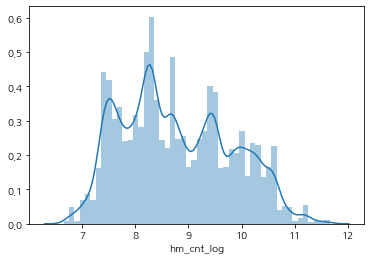

In [6]:
sns.distplot(data['hm_cnt_log'].dropna())

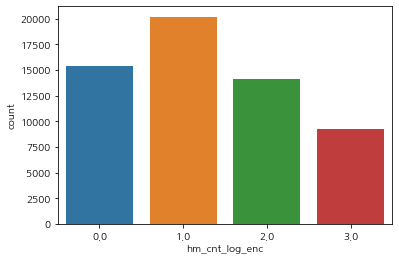

In [8]:
sns.countplot(data['hm_cnt_log_enc'])

In [6]:
data = pp3_func.date_author_pre(data, train=True)
data_val = pp3_func.date_author_pre(data_val, train=False)

In [7]:
data['dt_of_athrztn_rflct_log'] =  np.log(2020 - data['dt_of_athrztn'])
data_val['dt_of_athrztn_rflct_log'] =  np.log(2020 - data_val['dt_of_athrztn'])

-----------

In [8]:
data.loc[data["bldng_us"].values == "제1종근린생활시설", "bldng_us"] = None
data.loc[data["bldng_us"].values == "제2종근린생활시설", "bldng_us"] = None
data_val.loc[data_val["bldng_us"].values == "제1종근린생활시설", "bldng_us"] = None
data_val.loc[data_val["bldng_us"].values == "제2종근린생활시설", "bldng_us"] = None

one_hot_bldng_us = pd.get_dummies(data["bldng_us"])
data = data.join(one_hot_bldng_us)
one_hot_bldng_us = pd.get_dummies(data_val["bldng_us"])
data_val = data_val.join(one_hot_bldng_us)

In [9]:
A = ["목구조", "일반목구조", "벽돌구조", "블록구조", "석구조", "조적구조"]
B = ["강파이프구조", "경량철골구조", "기타강구조", "기타구조", "기타조적구조"]
C = ["일반철골구조", "철골철근콘크리트구조", "철골콘크리트구조", "철근콘크리트구조"]

for i in A:
    data.loc[data["bldng_archtctr"].values == i, "bldng_archtctr_encoded"] = "A"
for i in B:
    data.loc[data["bldng_archtctr"].values == i, "bldng_archtctr_encoded"] = "B" 
for i in C:
    data.loc[data["bldng_archtctr"].values == i, "bldng_archtctr_encoded"] = "C"

for i in A:
    data_val.loc[data_val["bldng_archtctr"].values == i, "bldng_archtctr_encoded"] = "A"
for i in B:
    data_val.loc[data_val["bldng_archtctr"].values == i, "bldng_archtctr_encoded"] = "B"    
for i in C:
    data_val.loc[data_val["bldng_archtctr"].values == i, "bldng_archtctr_encoded"] = "C"
    
one_hot_bldng_archtctr = pd.get_dummies(data["bldng_archtctr_encoded"])
data = data.join(one_hot_bldng_archtctr)

one_hot_bldng_archtctr = pd.get_dummies(data_val["bldng_archtctr_encoded"])
data_val = data_val.join(one_hot_bldng_archtctr)

data = data.drop("bldng_archtctr", 1)
data_val = data_val.drop("bldng_archtctr", 1)
data = data.drop("bldng_archtctr_encoded", 1)
data_val = data_val.drop("bldng_archtctr_encoded", 1)


In [10]:
data["dt_of_athrztn"] = data["dt_of_athrztn"].astype(str)
data_val["dt_of_athrztn"] = data_val["dt_of_athrztn"].astype(str)

In [11]:
data["year_athrztn"] = data["dt_of_athrztn"].apply(lambda x : x[:4])
data_val["year_athrztn"] = data_val["dt_of_athrztn"].apply(lambda x : x[:4])

year_athrztn_notnull = data[(data["year_athrztn"]!="nan")]
year_athrztn_YYYY = year_athrztn_notnull[year_athrztn_notnull["year_athrztn"].astype(int)<3000]
year_athrztn_YY = year_athrztn_notnull[year_athrztn_notnull["year_athrztn"].astype(int)>3000]
year_athrztn_null = data[data["year_athrztn"]=="nan"]

year_athrztn_YY["year_athrztn"] = 1900 + year_athrztn_YY["dt_of_athrztn"].str[:2].astype(int)
year_athrztn_notnull = year_athrztn_YYYY.append(year_athrztn_YY)
year_athrztn_median=year_athrztn_notnull["year_athrztn"].median()
year_athrztn_null["year_athrztn"]=year_athrztn_median

data = year_athrztn_notnull.append(year_athrztn_null)
data_val.loc[data_val["year_athrztn"]=="nan","year_athrztn"]= data_val[data_val["year_athrztn"]!="nan"]["year_athrztn"].median()

data["year_athrztn"] = data["year_athrztn"].astype(float).astype(int)
data_val["year_athrztn"] = data_val["year_athrztn"].astype(float).astype(int)

data.loc[data["year_athrztn"]<2000,"year_athrztn_encoded"] = "old"
data.loc[data["year_athrztn"]>1999,"year_athrztn_encoded"] = "new"

data_val.loc[data_val["year_athrztn"]<2000,"year_athrztn_encoded"] = "old"
data_val.loc[data_val["year_athrztn"]>1999,"year_athrztn_encoded"] = "new"


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':


In [12]:
data.loc[data["trgt_crtr"]=="자동화재탐지설치대상", "auto_fr"] = 1
data.loc[data["trgt_crtr"]!="자동화재탐지설치대상", "auto_fr"] = 0
data.loc[data["trgt_crtr"]=="옥내소화전설치대상", "fireplug"] = 1
data.loc[data["trgt_crtr"]!="옥내소화전설치대상", "fireplug"] = 0
data.loc[data["trgt_crtr"]=="스프링클러,물분무등설치대상", "sprinkler"] = 1
data.loc[data["trgt_crtr"]!="스프링클러,물분무등설치대상", "sprinkler"] = 0

data_val.loc[data_val["trgt_crtr"]=="자동화재탐지설치대상", "auto_fr"] = 1
data_val.loc[data_val["trgt_crtr"]!="자동화재탐지설치대상", "auto_fr"] = 0
data_val.loc[data_val["trgt_crtr"]=="옥내소화전설치대상", "fireplug"] = 1
data_val.loc[data_val["trgt_crtr"]!="옥내소화전설치대상", "fireplug"] = 0
data_val.loc[data_val["trgt_crtr"]=="스프링클러,물분무등설치대상", "sprinkler"] = 1
data_val.loc[data_val["trgt_crtr"]!="스프링클러,물분무등설치대상", "sprinkler"] = 0

data = data.drop("trgt_crtr", 1)
data_val = data_val.drop("trgt_crtr", 1)

In [13]:
data.loc[data["fr_fghtng_fclt_spcl_css_6_yn"].isnull(),"css_6_yn_encoded"]=0
data.loc[data["fr_fghtng_fclt_spcl_css_6_yn"].notnull(),"css_6_yn_encoded"]=1

data_val.loc[data_val["fr_fghtng_fclt_spcl_css_6_yn"].isnull(),"css_6_yn_encoded"]=0
data_val.loc[data_val["fr_fghtng_fclt_spcl_css_6_yn"].notnull(),"css_6_yn_encoded"]=1

data = data.drop("fr_fghtng_fclt_spcl_css_5_yn", 1)
data = data.drop("fr_fghtng_fclt_spcl_css_6_yn", 1)
data_val = data_val.drop("fr_fghtng_fclt_spcl_css_5_yn", 1)
data_val = data_val.drop("fr_fghtng_fclt_spcl_css_6_yn", 1)

In [14]:
one_hot_us_yn = pd.get_dummies(data["us_yn"])
data = data.join(one_hot_us_yn)

one_hot_us_yn = pd.get_dummies(data_val["us_yn"])
data_val = data_val.join(one_hot_us_yn)

data = data.drop("us_yn", 1)
data_val = data_val.drop("us_yn", 1)

In [15]:
data.loc[data["dngrs_thng_yn"].isnull(),"dngrs_thng_yn_encoded"]= 0
data.loc[data["dngrs_thng_yn"].notnull(),"dngrs_thng_yn_encoded"]= 1
data_val.loc[data_val["dngrs_thng_yn"].isnull(),"dngrs_thng_yn_encoded"]= 0
data_val.loc[data_val["dngrs_thng_yn"].notnull(),"dngrs_thng_yn_encoded"]= 1

data = data.drop("dngrs_thng_yn", 1)
data_val = data_val.drop("dngrs_thng_yn", 1)

data.loc[data["slf_fr_brgd_yn"].isnull(),"slf_fr_brgd_yn"]=0
data = data.drop("slf_fr_brgd_yn", 1)
data_val = data_val.drop("slf_fr_brgd_yn", 1)

data = data.drop("blk_dngrs_thng_mnfctr_yn", 1)
data_val = data_val.drop("blk_dngrs_thng_mnfctr_yn", 1)

data = data.drop("cltrl_hrtg_yn", 1)
data_val = data_val.drop("cltrl_hrtg_yn", 1)

In [35]:
# delete cell
data.loc[data["bldng_ar"]==0, "bldng_ar"] = data["bldng_ar"].median()
data.loc[data["ttl_ar"]==0, "ttl_ar"] = data["ttl_ar"].median()
data_val.loc[data_val["bldng_ar"]==0, "bldng_ar"] = data_val["bldng_ar"].median()
data_val.loc[data_val["ttl_ar"]==0, "ttl_ar"] = data_val["ttl_ar"].median()

data = data.drop("lnd_ar", 1)
data_val = data_val.drop("lnd_ar", 1)

data = data.drop("dt_of_athrztn", 1)
data_val = data_val.drop("dt_of_athrztn", 1)

- Weather

In [16]:
data = pp2nd_func.wnd_drctn_enc(data)
data_val = pp2nd_func.wnd_drctn_enc(data_val)
data = pp3_func.Wnd_spd_log(data)
data_val = pp3_func.Wnd_spd_log(data_val)

In [24]:
data[['season','season_mean_differ','hmdt','wnd_drctn_enc','wnd_spd_log','tmprtr']].isnull().sum()

season                 0
season_mean_differ    13
hmdt                  22
wnd_drctn_enc          0
wnd_spd_log           33
tmprtr                13
dtype: int64

In [17]:
data['wnd_drctn_enc'] = data['wnd_drctn_enc'].astype('category')
data['season'] = data['season'].astype('category')
data['wnd_drctn_enc'] = data['wnd_drctn_enc'].astype('category')
weather_imputer = IterativeImputer(n_nearest_features=5 , max_iter=50, tol= 0.0001)
weather_data = data[['season','season_mean_differ','hmdt','wnd_drctn_enc','wnd_spd_log','tmprtr']]
weather_imp_res = weather_imputer.fit_transform(weather_data)
weather_imp_df = pd.DataFrame(weather_imp_res, columns=weather_data.columns)
data = pd.concat([data.drop(columns=['season_mean_differ','hmdt','wnd_spd_log','tmprtr']) , weather_imp_df[['season_mean_differ','hmdt','wnd_spd_log','tmprtr']]], axis=1)

In [18]:
data_val = pp3_func.Weather(data_val, weather_imputer)
data_val = pp3_func.Wnd_spd_log(data_val)

- jmk

In [19]:
data = pp3_func.Jmk_enc(data)
data_val = pp3_func.Jmk_enc(data_val)

In [20]:
data = pp3_func.Fr_mn_cnt(data)
data_val = pp3_func.Fr_mn_cnt(data_val)

In [21]:
data = pp3_func.regional_name_pre(data)
data_val = pp3_func.regional_name_pre(data_val)

- bldng_prc

In [22]:
data.reset_index(drop=True, inplace=True)
data_val.reset_index(drop=True, inplace=True)

In [23]:
data['bldng_ar_prc_log'] = np.log(data['bldng_ar_prc'])
data_val['bldng_ar_prc_log'] = np.log(data_val['bldng_ar_prc'])

In [24]:
bldng_ar_prc_imputer = IterativeImputer( min_value=9.77 , max_value = 16.5, max_iter=30 )
bldng_ar_prc_impres = bldng_ar_prc_imputer.fit_transform(data[['bldng_ar_prc_log','dt_of_athrztn_enc','dt_of_athrztn_rflct_log','hm_cnt_log','bldng_ar','ttl_ar','ttl_grnd_flr','fr_wthr_fclt_dstnc','tbc_rtl_str_dstnc','ele_mean','rgnl_ar_nm_enc','jmk_enc']])
bldng_ar_prc_df = pd.DataFrame(bldng_ar_prc_impres, columns = ['bldng_ar_prc_log','dt_of_athrztn_enc','dt_of_athrztn_rflct_log','hm_cnt_log','bldng_ar','ttl_ar','ttl_grnd_flr','fr_wthr_fclt_dstnc','tbc_rtl_str_dstnc','ele_mean','rgnl_ar_nm_enc','jmk_enc'])
data = pd.concat([data.drop(columns = ['bldng_ar_prc_log','hm_cnt_log']), bldng_ar_prc_df[['bldng_ar_prc_log','hm_cnt_log']]], axis=1)

In [25]:
data_val = pp3_func.building_price(data_val, bldng_ar_prc_imputer)

In [26]:
data = pp3_func.Hm_cnt_log_enc(data)
data_val = pp3_func.Hm_cnt_log_enc(data_val)

- rgnl_ar_nm

In [27]:
data.reset_index(drop=True, inplace=True)
data_val.reset_index(drop=True, inplace=True)

In [28]:
rgnl_ar_imputer = IterativeImputer(n_nearest_features=7, min_value=0, max_value=5, max_iter=30)
rgnl_ar_impres = rgnl_ar_imputer.fit_transform(data[['rgnl_ar_nm_enc','bldng_ar_prc_log','bldng_ar_prc','jmk_enc','hm_cnt_log','hm_cnt','bldng_ar','ttl_ar','jmk_enc']])
rgnl_ar_df = pd.DataFrame(rgnl_ar_impres, columns=['rgnl_ar_nm_enc','bldng_ar_prc_log','bldng_ar_prc','jmk_enc','hm_cnt_log','hm_cnt','bldng_ar','ttl_ar','jmk_enc'])
data = pd.concat([data.drop(columns = 'rgnl_ar_nm_enc'), rgnl_ar_df['rgnl_ar_nm_enc']], axis=1)
data['rgnl_ar_nm_enc'] = np.round(data['rgnl_ar_nm_enc'])

In [29]:
data_val = pp3_func.regional_name_post(data_val, rgnl_ar_imputer)
data_val['rgnl_ar_nm_enc'] = np.round(data_val['rgnl_ar_nm_enc'])

- dt_of_athrztn

In [30]:
data.reset_index(drop=True, inplace=True)
data_val.reset_index(drop=True, inplace=True)

In [31]:
data['dt_of_athrztn_enc'] = data['dt_of_athrztn_enc'].astype('category')

In [32]:
dt_of_ath_imputer = IterativeImputer( n_nearest_features=7, min_value=0, max_value=4, max_iter=30 )
dt_of_ath_res = dt_of_ath_imputer.fit_transform(data[['dt_of_athrztn_enc','dt_of_athrztn_rflct_log','bldng_cnt','bldng_ar','jmk_enc','gas_mean','ele_mean','hm_cnt','hm_cnt_log','tbc_rtl_str_dstnc','bldng_ar_prc_log','bldng_ar_prc','rgnl_ar_nm_enc']])
dt_of_ath_df = pd.DataFrame(dt_of_ath_res , columns = ['dt_of_athrztn_enc','dt_of_athrztn_rflct_log','bldng_cnt','bldng_ar','jmk_enc','gas_mean','ele_mean','hm_cnt','hm_cnt_log','tbc_rtl_str_dstnc','bldng_ar_prc_log','bldng_ar_prc','rgnl_ar_nm_enc'])
data = pd.concat([data.drop(columns = ['dt_of_athrztn_enc','dt_of_athrztn_rflct_log']), dt_of_ath_df[['dt_of_athrztn_enc','dt_of_athrztn_rflct_log']]] ,axis=1)
data['dt_of_athrztn_enc'] = np.round(data['dt_of_athrztn_enc'])

In [33]:
data_val = pp3_func.date_author_post(data_val, dt_of_ath_imputer )
data_val['dt_of_athrztn_enc'] = np.round(data_val['dt_of_athrztn_enc'])

- bldng_ar, ttl_ar, lnd_ar

In [37]:
data.reset_index(drop=True, inplace=True)
data_val.reset_index(drop=True, inplace=True)

In [38]:
data['bldng_ar_log'] = np.log(data['bldng_ar'])
data['ttl_ar_log'] = np.log(data['ttl_ar'])
data['lnd_ar_log'] = np.log(data['lnd_ar'])
data_val = pp3_func.log_maker(data_val, 'bldng_ar')
data_val = pp3_func.log_maker(data_val, 'ttl_ar')
data_val = pp3_func.log_maker(data_val, 'lnd_ar')
# data_val.rename(columns={'lnd_ar_log' : 'lnd_log'},inplace=True)

In [39]:
ar_imputer = IterativeImputer( max_iter=30)
ar_impres = ar_imputer.fit_transform(data[['ttl_ar_log','bldng_ar_log','lnd_ar_log','hm_cnt_log','fr_mn_cnt','rgnl_ar_nm_enc','dt_of_athrztn_enc','jmk_enc','bldng_ar_prc_log','fr_wthr_fclt_dstnc','tbc_rtl_str_dstnc']])
ar_df = pd.DataFrame(ar_impres, columns = ['ttl_ar_log','bldng_ar_log','lnd_ar_log','hm_cnt_log','fr_mn_cnt','rgnl_ar_nm_enc','dt_of_athrztn_enc','jmk_enc','bldng_ar_prc_log','fr_wthr_fclt_dstnc','tbc_rtl_str_dstnc'])
data = pd.concat([data.drop(columns = ['ttl_ar_log','bldng_ar_log','lnd_ar_log']), ar_df[['ttl_ar_log','bldng_ar_log','lnd_ar_log']]], axis=1)

In [40]:
data_val = pp3_func.area_predict(data_val, ar_imputer)

In [37]:
binary_dic = {7: 1, 8:1, 9:1, 10:1, 11:1, 12:1, 13:1, 14:1, 15:1, 16:1, 17:1, 18:1, 19:1,20:1, 21:0, 22:0, 23:0, 0:0, 1:0, 2:0, 3:0, 4:0, 5:0, 6:0}
data['dt_of_fr_hr_enc'] = data['dt_of_fr_hr'].map(binary_dic)
data_val['dt_of_fr_hr_enc'] = data_val['dt_of_fr_hr'].map(binary_dic)

# modeling

In [42]:
# data.drop(columns='id',inplace=True)
# data_val.drop(columns='id',inplace=True)
train_x = data.drop(columns=['dt_of_fr','fr_yn'])
train_y = data['fr_yn']
val_x = data_val.drop(columns=['dt_of_fr','fr_yn'])
val_y = data_val['fr_yn']
train_x = train_x.fillna(-1)
X_val = X_val.fillna(-1)

In [43]:
data.columns[data.isnull().sum()==0]

Index(['dt_of_fr', 'fr_yn', 'bldng_cnt', 'jmk', 'id', 'emd_nm',
       'fr_sttn_dstnc', 'fr_wthr_fclt_dstnc', 'fr_mn_cnt', 'mlt_us_yn',
       'cctv_dstnc', 'fr_wthr_fclt_in_100m', 'cctv_in_100m',
       'tbc_rtl_str_dstnc', 'sft_emrgnc_bll_dstnc', 'ahsm_dstnc',
       'no_tbc_zn_dstnc', 'bldng_cnt_in_50m', 'emd_nm_big', 'emd_nm_small',
       'dt_of_fr_yr', 'dt_of_fr_hr', 'dt_of_fr_mth', 'season', 'gas_mean',
       'ele_mean', 'hm_cnt_log_enc', 'wnd_drctn_enc', 'season_mean_differ',
       'hmdt', 'wnd_spd_log', 'tmprtr', 'jmk_enc', 'bldng_ar_prc_log',
       'hm_cnt_log', 'rgnl_ar_nm_enc', 'dt_of_athrztn_enc',
       'dt_of_athrztn_rflct_log', 'ttl_ar_log', 'bldng_ar_log', 'lnd_ar_log',
       'dt_of_fr_hr_enc'],
      dtype='object')

In [110]:
dataset = data[['bldng_cnt','jmk_enc','fr_sttn_dstnc','fr_wthr_fclt_dstnc','fr_mn_cnt','fr_wthr_fclt_in_100m','tbc_rtl_str_dstnc',
                'no_tbc_zn_dstnc','bldng_cnt_in_50m','dt_of_fr_hr_enc','dt_of_fr_hr','dt_of_fr_mth','season','gas_mean','ele_mean','hm_cnt_log_enc',
                'wnd_drctn_enc','season_mean_differ','hmdt','wnd_spd_log','tmprtr','bldng_ar_prc_log','hm_cnt_log','rgnl_ar_nm_enc',
                'dt_of_athrztn_enc', 'dt_of_athrztn_rflct_log','ttl_ar_log', 'bldng_ar_log', 'lnd_ar_log','fr_yn']]

In [111]:
dataset = pp3_func.from_category_to_int(dataset)

In [102]:
dataset.isnull().sum()

bldng_cnt                  0
jmk_enc                    0
fr_sttn_dstnc              0
fr_wthr_fclt_dstnc         0
fr_mn_cnt                  0
fr_wthr_fclt_in_100m       0
tbc_rtl_str_dstnc          0
no_tbc_zn_dstnc            0
bldng_cnt_in_50m           0
dt_of_fr_hr_enc            0
dt_of_fr_hr                0
dt_of_fr_mth               0
season                     0
gas_mean                   0
ele_mean                   0
hm_cnt_log_enc             0
wnd_drctn_enc              0
season_mean_differ         0
hmdt                       0
wnd_spd_log                0
tmprtr                     0
bldng_ar_prc_log           0
hm_cnt_log                 0
rgnl_ar_nm_enc             0
dt_of_athrztn_enc          0
dt_of_athrztn_rflct_log    0
ttl_ar_log                 0
bldng_ar_log               0
lnd_ar_log                 0
fr_yn                      0
dtype: int64

In [112]:
lgbm_ = lgbm.LGBMClassifier( reg_alpha=0.3, reg_lambda=0.3)
lgbm_.fit(dataset.iloc[:,:-1], dataset['fr_yn'])
yhat = lgbm_.predict(dataset.iloc[:,:-1])
f1_score(dataset['fr_yn'], yhat)

0.52011144001393

In [43]:
lgbm_ = lgbm.LGBMClassifier( reg_alpha=0.3, reg_lambda=0.3)
lgbm_.fit(train_x, train_y)
yhat = lgbm_.predict(dataset.iloc[:,:-1])
f1_score(dataset['fr_yn'], yhat)

ValueError: DataFrame.dtypes for data must be int, float or bool.
Did not expect the data types in the following fields: bldng_us, bldng_us_clssfctn, jmk, rgnl_ar_nm, rgnl_ar_nm2, lnd_us_sttn_nm, rd_sd_nm, emd_nm, emd_nm_big, emd_nm_small, year_athrztn_encoded

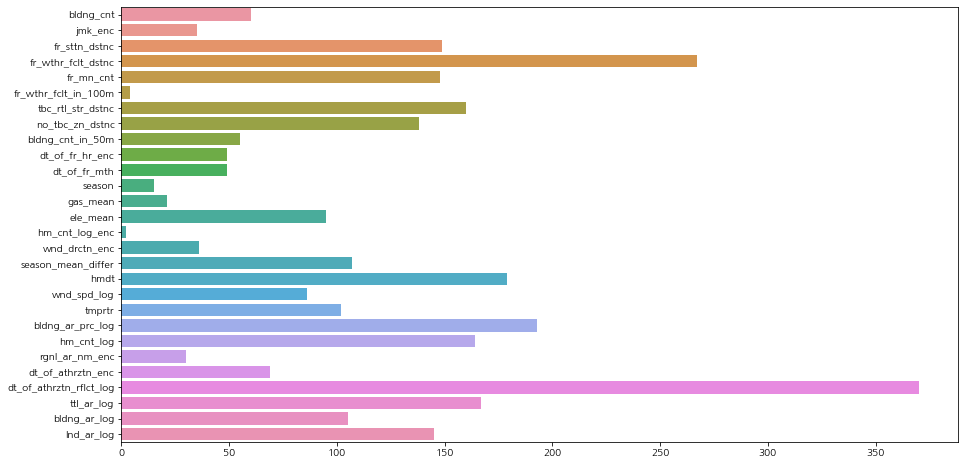

In [96]:
plt.figure(figsize=(15,8))
sns.barplot(x = lgbm_.feature_importances_, y = dataset.columns[:-1])

In [104]:
xgb_ = XGBClassifier(max_depth=7)
xgb_.fit(dataset.iloc[:,:-1], dataset['fr_yn'])
xgb_yhat = xgb_.predict(dataset.iloc[:,:-1])
f1_score(dataset['fr_yn'], xgb_yhat)

0.5813095340255727

In [105]:
yhat_prob = lgbm_.predict_proba(dataset.iloc[:,:-1])
xgb_yhat_prob = xgb_.predict_proba(dataset.iloc[:,:-1])
ensemble = yhat_prob* 0.5 + xgb_yhat_prob*0.5
en_yhat = np.argmax(ensemble,axis=1)

In [106]:
f1_score(dataset['fr_yn'], en_yhat)

0.5495401700503211

# adasyn

In [56]:
from imblearn.over_sampling import ADASYN

Using TensorFlow backend.
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:529: FutureWarn

In [57]:
ada = ADASYN()

In [58]:
ada_x, ada_y = ada.fit_resample(dataset.iloc[:,:-1], dataset['fr_yn'])

In [90]:
lgbm_ = lgbm.LGBMClassifier()
lgbm_.fit(ada_x, ada_y )
yhat = lgbm_.predict(dataset.iloc[:,:-1])
f1_score(dataset['fr_yn'], yhat)

0.5011140991164041

In [81]:
xgb_ = XGBClassifier(max_depth = 7)
xgb_.fit(ada_x, ada_y)
xgb_yhat = xgb_.predict(dataset.iloc[:,:-1])
xgb_yhat_prob = xgb_.predict_proba(dataset.iloc[:,:-1])
f1_score(dataset['fr_yn'], xgb_yhat)

0.5920857727304789

## validation!

In [98]:
dataset_val = data_val[['bldng_cnt','jmk_enc','fr_sttn_dstnc','fr_wthr_fclt_dstnc','fr_mn_cnt','fr_wthr_fclt_in_100m','tbc_rtl_str_dstnc',
                'no_tbc_zn_dstnc','bldng_cnt_in_50m','dt_of_fr_hr_enc','dt_of_fr_hr','dt_of_fr_mth','season','gas_mean','ele_mean','hm_cnt_log_enc',
                'wnd_drctn_enc','season_mean_differ','hmdt','wnd_spd_log','tmprtr','bldng_ar_prc_log','hm_cnt_log','rgnl_ar_nm_enc',
                'dt_of_athrztn_enc', 'dt_of_athrztn_rflct_log','ttl_ar_log', 'bldng_ar_log', 'lnd_ar_log','fr_yn']]

In [140]:
# dataset_val.dropna(inplace=True)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [99]:
dataset_val = pp3_func.from_category_to_int(dataset_val)

../pp_3rd/pp3_func.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  dataset['dt_of_athrztn_enc']  = dataset['dt_of_athrztn_enc'].astype('int')
../pp_3rd/pp3_func.py:191: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  dataset['rgnl_ar_nm_enc']  = dataset['rgnl_ar_nm_enc'].astype('int')
../pp_3rd/pp3_func.py:192: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stabl

In [107]:
yhat_val = lgbm_.predict(dataset_val.iloc[:,:-1])
# yhat_prob_val = lgbm_.predict_proba(dataset_val.iloc[:,:-1])
f1_score(dataset_val['fr_yn'], yhat_val)

0.45411542100283825

In [108]:
xgb_yhat_val = xgb_.predict(dataset_val.iloc[:,:-1])
# xgb_yhat_prob_val = xgb_.predict_proba(dataset_val.iloc[:,:-1])
f1_score(dataset_val['fr_yn'], xgb_yhat_val)

0.4521656354117087

In [109]:
yhat_prob = lgbm_.predict_proba(dataset_val.iloc[:,:-1])
xgb_yhat_prob = xgb_.predict_proba(dataset_val.iloc[:,:-1])
ensemble_val = yhat_prob* 0.5 + xgb_yhat_prob*0.5
en_yhat_val = np.argmax(ensemble_val,axis=1)
f1_score(dataset_val['fr_yn'], en_yhat_val)

0.452561669829222

# test

In [67]:
data_test = pd.read_csv('../raw/PJT002_test.csv')
data_test = pp2nd_func.replace(data_test)
data_test = pp2nd_func.label_encoding(data_test)
data_test = pp3_func.energy_mean(data_test) 
data_test = pp3_func.Hm_cnt(data_test)
data_test = pp2nd_func.wnd_drctn_enc(data_test)
data_test = pp3_func.Wnd_spd_log(data_test)
data_test = pp3_func.Weather(data_test, weather_imputer)
data_test = pp3_func.Wnd_spd_log(data_test)
data_test = pp3_func.Jmk_enc(data_test)
data_test = pp3_func.Fr_mn_cnt(data_test)
data_test = pp3_func.date_author_pre(data_test, train=False)
data_test['dt_of_athrztn_rflct_log'] =  np.log(2020 - data_test['dt_of_athrztn'])
data_test = pp3_func.regional_name_pre(data_test)
data_test.reset_index(drop=True, inplace=True)
data_test['bldng_ar_prc_log'] = np.log(data_test['bldng_ar_prc'])
data_test = pp3_func.building_price(data_test, bldng_ar_prc_imputer)
data_test = pp3_func.Hm_cnt_log_enc(data_test)
data_test.reset_index(drop=True, inplace=True)
data_test = pp3_func.regional_name_post(data_test, rgnl_ar_imputer)
data_test['rgnl_ar_nm_enc'] = np.round(data_test['rgnl_ar_nm_enc'])
data_test.reset_index(drop=True, inplace=True)
data_test = pp3_func.date_author_post(data_test, dt_of_ath_imputer )
data_test['dt_of_athrztn_enc'] = np.round(data_test['dt_of_athrztn_enc'])
data_test.reset_index(drop=True, inplace=True)
data_test = pp3_func.log_maker(data_test, 'bldng_ar')
data_test = pp3_func.log_maker(data_test, 'ttl_ar')
data_test = pp3_func.log_maker(data_test, 'lnd_ar')
data_test = pp3_func.area_predict(data_test, ar_imputer)
data_test['dt_of_fr_hr_enc'] = data_test['dt_of_fr_hr'].map(binary_dic)

/usr/local/lib/python3.6/dist-packages/pandas/core/ops.py:1649: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)


In [72]:
dataset_test = data_test[['bldng_cnt','jmk_enc','fr_sttn_dstnc','fr_wthr_fclt_dstnc','fr_mn_cnt','fr_wthr_fclt_in_100m','tbc_rtl_str_dstnc',
                'no_tbc_zn_dstnc','bldng_cnt_in_50m','dt_of_fr_hr_enc','dt_of_fr_mth','season','gas_mean','ele_mean','hm_cnt_log_enc',
                'wnd_drctn_enc','season_mean_differ','hmdt','wnd_spd_log','tmprtr','bldng_ar_prc_log','hm_cnt_log','rgnl_ar_nm_enc',
                'dt_of_athrztn_enc', 'dt_of_athrztn_rflct_log','ttl_ar_log', 'bldng_ar_log', 'lnd_ar_log']]
dataset_test = pp3_func.from_category_to_int(dataset_test)

../pp_3rd/pp3_func.py:195: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  dataset['season']  = dataset['season'].astype('int')


In [ ]:
yhat_prob = lgbm_.predict_proba(dataset.iloc[:,:-1])
xgb_yhat_prob = xgb_.predict_proba(dataset.iloc[:,:-1])
ensemble_val = yhat_prob* 0.5 + xgb_yhat_prob*0.5
en_yhat_val = np.argmax(ensemble_val,axis=1)
f1_score(dataset['fr_yn'], en_yhat_val)